# [T256075](https://phabricator.wikimedia.org/T256075) Post Deployment Data QA - Collapsible Sidebar Instrumentation

In this task we will be verifying if events fired in the test wikis are making it to the schema [DesktopWebUIActionsTracking](https://meta.wikimedia.org/wiki/Schema:DesktopWebUIActionsTracking) and if the Instrumentation is working correctly.  
**Part 1:**
- euwiki  
- frwiktionary
- ptwikiversity

**Part 2:**
- frwiki
- hewiki
- fawiki

Observations: 
- Ideally, since this instrumentation is deployed to test wikis that have the sidebar collapsed by default, we would expect events for new version to be higher than legacy version. However, skinVersion 1 is higher than version 2, probably due to the late rollout of Fr wiki. 
- We can see a rise in the clicks to sidebar button starting July 27, when the new skin version was rolled out to larger test wikis Fa and He and then stabilizes. 
- There is a rise on Aug 5 when the feature was rolled out to Fr wiki. We expect this rise to stabilize over time. This also indicates that Eventlogging is able to capture the surge in events correctly. 
- We would ideally want the # of events for isSidebarCollapsed = True to be greater than isSidebarCollapsed=False for all but Fr wiki, but that is Not the case.
- Since the number of anonymous (logged out) users is greater than logged in users, we would expect that the events for issidebarcollapsed for skinversion 2 to be greater than that for skinversion 1. However, we don't see this. Lets see if we need to Investigate further
- Looks like the new skinVersion is driving Anonymous (logged out user) traffic toward the Donate link on Fa, Eu, He wikis ! 

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pandas as pd
from tabulate import tabulate
from wmfdata import charting, hive, mariadb
from wmfdata.charting import comma_fmt, pct_fmt
from wmfdata.utils import df_to_remarkup, pct_str
import matplotlib.ticker as ticker
@ticker.FuncFormatter
def million_formatter(x, pos):
    return "%d M" % round(x/1000000)
@ticker.FuncFormatter
def thousand_formatter(x, pos):
    return "%d K" % round(x/1000)

### Count events in DesktopWebUIActionsTracking

In [4]:
# Count all events  

count_actions = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.action AS action,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND ((month=7 AND day > 20) OR month=8)  
  AND wiki <> 'testwiki'
GROUP BY date_format(dt, "yyyy-MM-dd"), event.action
""")

In [8]:
count_actions_pivot=count_actions.pivot(index="date",columns='action', values='events').fillna(0)

In [9]:
count_actions_pivot.style.format('{:,}')

action,click,init
date,,
2020-07-22,618,"22,058"
2020-07-23,829,"33,483"
2020-07-24,604,"30,211"
2020-07-25,551,"22,408"
2020-07-26,735,"24,982"
2020-07-27,"5,922","369,904"
2020-07-28,"26,892","1,613,566"
2020-07-29,"26,605","1,539,623"
2020-07-30,"24,403","1,478,869"


In [11]:
count_actions_pivot=count_actions_pivot.reset_index()

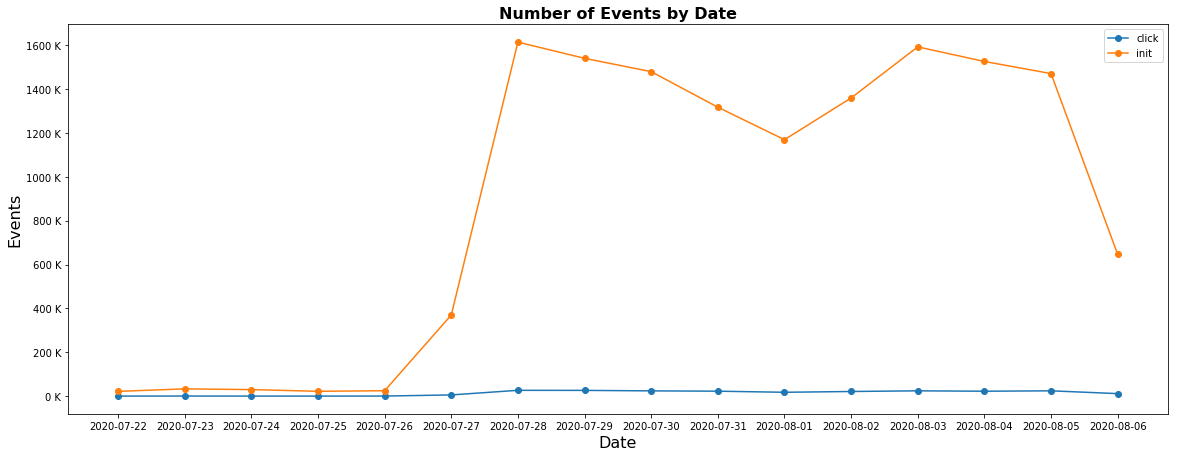

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(16,6))
fig.tight_layout(pad=1.08, w_pad=0.5, h_pad=6)
ax.set_title('Number of Events by Date',fontweight="bold",fontsize = 16)
ax.set_xlabel('Date',  fontsize = 16)
ax.set_ylabel('Events',  fontsize = 16)
ax.plot(count_actions_pivot["date"], 
        count_actions_pivot['click'], 'o-', label='click')
ax.plot(count_actions_pivot["date"], 
        count_actions_pivot['init'], 'o-', label='init')


ax.yaxis.set_major_formatter(thousand_formatter)
ax.legend(loc='upper right')

plt.show()

### Count events by Wiki

In [13]:
# Check by Wiki 

count_actions_wiki = hive.run("""
SELECT
  wiki AS wiki,
  event.action AS action,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND ((month=7 AND day > 20) OR month=8)   
  AND wiki <>'testwiki' 
GROUP BY wiki, event.action
""")

In [16]:
count_actions_wiki_pivot=count_actions_wiki.pivot_table(index=["wiki"],
                                                        columns=["action"]).fillna(0)
count_actions_wiki_pivot.style.format('{:,}')

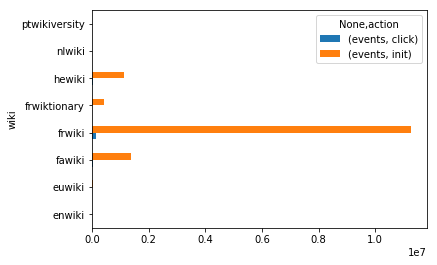

In [18]:
count_actions_wiki_pivot.plot.barh()

### Count events by Browser

In [19]:
# Check by Wiki 

count_actions_browser = hive.run("""
SELECT
  useragent.browser_family AS browser,
  event.action AS action,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND ((month=7 AND day > 20) OR month=8)   
  AND wiki <>'testwiki' 
GROUP BY useragent.browser_family, event.action
""")

In [22]:
count_actions_browser_pivot=count_actions_browser.pivot_table(index=["browser"],
                                                        columns=["action"]).fillna(0)
count_actions_browser_pivot.style.format('{:,}')

### Count events by skinVersion

In [23]:
# Check by skinVersion 

count_actions_skinVersion = hive.run("""
SELECT
  event.action AS action,
  event.skinversion as skinversion,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND ((month=7 AND day > 20) OR month=8)   
  AND wiki <> 'testwiki'
GROUP BY event.action, event.skinversion
""")

In [24]:
count_actions_skinVersion.pivot(index='skinversion', columns='action').style.format('{:,}')

<font color='dark red'> 
    Ideally, since this instrumentation is deployed to test wikis that have the sidebar collapsed by default, we would expect events for new version to be higher than legacy version. However, skinVersion 1 is higher than version 2, probably due to the late rollout of Fr wiki. 
</font>

### Count of events by skinVersion on test wikis

In [25]:
# Check by skinVersion and wiki

count_actions_skinVersion_wiki = hive.run("""
SELECT
  event.action AS action,
  event.skinversion as skinversion,
  wiki AS wiki,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND ((month=7 AND day > 20) OR month=8)   
GROUP BY event.action, event.skinversion, wiki
""")

In [26]:
count_actions_skinVersion_wiki_pivot=count_actions_skinVersion_wiki.pivot_table(index=['wiki','skinversion'],
                                                                                columns=['action']).fillna(0)

In [27]:
count_actions_skinVersion_wiki_pivot.style.format('{:,}')

<font color='dark red'> 
    The new Vector skin (skinversion=2) was rolled out as Default on all test wikis except Fr wiki. Hence, skinVersion 2 has greater number of events than skinVersion 1 (legacy Vector). Fr wiki was rolled out Aug 4-5 and should start seeing an increase in the number of version 2 events going forward. 
</font>

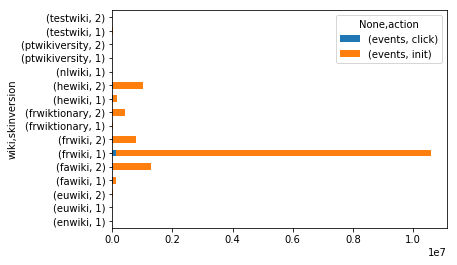

In [28]:
ax = count_actions_skinVersion_wiki_pivot.plot.barh(stacked=True)

In [29]:
# Check by skinVersion and Browser

count_actions_skinVersion_browser = hive.run("""
SELECT
  event.action AS action,
  event.skinversion as skinversion,
  useragent.browser_family AS browser,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND ((month=7 AND day > 20) OR month=8)   
GROUP BY event.action, event.skinversion, useragent.browser_family
""")

### Count of events by skinVersion on different browsers

In [30]:
count_actions_skinVersion_browser_pivot=count_actions_skinVersion_browser.pivot_table(index=['browser','skinversion'],
                                                                                columns=['action']).fillna(0)
count_actions_skinVersion_browser_pivot.style.format('{:,}')

### Clicks to the Collapsible Sidebar

In [31]:
# Collapsible sidebar events by Date

count_actions_sidebar = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.name as name,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND ((month=7 AND day > 20) OR month=8)   
  AND event.name LIKE 'ui.%'
  AND wiki <> 'testwiki'
GROUP BY date_format(dt, "yyyy-MM-dd"), event.name
""")

**Please note : this excludes [Testwiki](https://test.wikipedia.org/wiki/Main_Page)**

In [60]:
count_actions_sidebar_pivot=count_actions_sidebar.pivot(index='date', columns='name')
count_actions_sidebar_pivot.tail()

,events
name,ui.sidebar
date,
2020-08-02,523
2020-08-03,559
2020-08-04,441
2020-08-05,3632
2020-08-06,1668


In [33]:
count_actions_sidebar_pivot=count_actions_sidebar_pivot.reset_index()

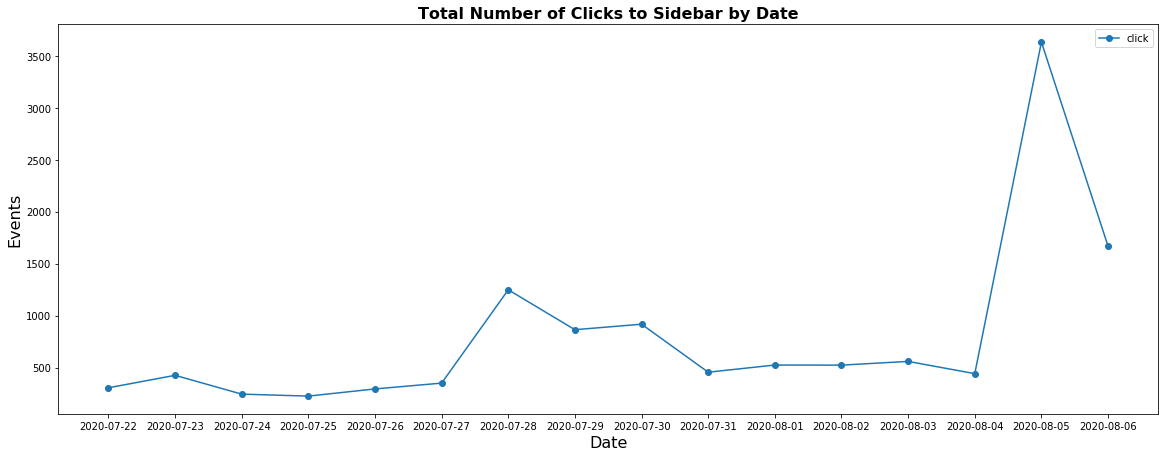

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(16,6))
fig.tight_layout(pad=1.08, w_pad=0.5, h_pad=6)
ax.set_title('Total Number of Clicks to Sidebar by Date',fontweight="bold",fontsize = 16)
ax.set_xlabel('Date',  fontsize = 16)
ax.set_ylabel('Events',  fontsize = 16)
ax.plot(count_actions_sidebar_pivot["date"], 
        count_actions_sidebar_pivot['events'], 'o-', label='click')

#ax.yaxis.set_major_formatter(thousand_formatter)
ax.legend(loc='upper right')

plt.show()

<font color='dark red'> 
    We can see a rise in the clicks to sidebar button starting July 27, when the new skin version was rolled out to larger test wikis Fa and He and then stabilizes. 
    There is a rise on Aug 5 when the feature was rolled out to Fr wiki. We expect this rise to stabilize over time. This also indicates that Eventlogging is able to capture the surge in events. 
</font>

In [43]:
# Collapsible sidebar events by Wiki and date

count_actions_sidebarwiki = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.name as name,
  wiki AS wiki,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND ((month=7 AND day > 23) OR month=8)   
  AND event.name LIKE 'ui.%'
  AND wiki <> 'testwiki'
GROUP BY date_format(dt, "yyyy-MM-dd"), event.name, wiki
""")

### Clicks to the Sidebar Button by Wiki

In [44]:
count_actions_sidebarwiki_pivot=count_actions_sidebarwiki.pivot_table(index=['name','date'], 
                                                                      columns=['wiki']).fillna(0)

In [45]:
count_actions_sidebarwiki_pivot.style.format('{:,}')

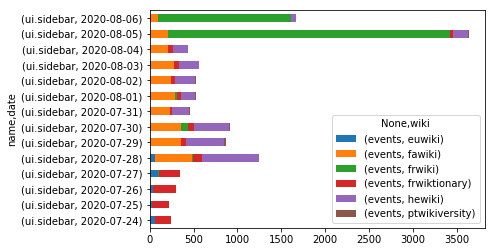

In [66]:
ax = count_actions_sidebarwiki_pivot.plot.barh(stacked=True)

### Status of isSidebarCollapsed True/False 

In [35]:
# Collapsible sidebar events 

count_actions_isSidebarCollapsed = hive.run("""
SELECT
  event.isSidebarCollapsed AS isSidebarCollapsed ,
  event.action AS action,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND ((month=7 AND day > 20) OR month=8)   
  AND wiki <> 'testwiki'
GROUP BY event.isSidebarCollapsed, event.action
""")

In [68]:
count_actions_isSidebarCollapsed.pivot_table(index=['issidebarcollapsed'],
                                             columns=['action']).style.format('{:,}')

In [37]:
# Collapsible sidebar events by Date

count_actions_isSidebarCollapsed_date = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.isSidebarCollapsed AS isSidebarCollapsed ,
  event.action AS action,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND ((month=7 AND day > 23) OR month=8)   
  AND wiki <> 'testwiki'
GROUP BY date_format(dt, "yyyy-MM-dd"), event.isSidebarCollapsed, event.action
""")

In [38]:
count_actions_isSidebarCollapsed_date.pivot_table(index=['issidebarcollapsed','action'], 
                                                  columns=['date']).style.format('{:,}')

In [39]:
# Collapsible sidebar events 

count_actions_isSidebarCollapsed_wiki = hive.run("""
SELECT
  event.isSidebarCollapsed AS isSidebarCollapsed ,
  event.action AS action,
  wiki AS wiki,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND ((month=7 AND day > 23) OR month=8)   
  AND wiki <> 'testwiki'
GROUP BY event.isSidebarCollapsed, event.action, wiki
""")

### isSidebarCollapsed True/False by Wiki

In [40]:
count_actions_isSidebarCollapsed_wiki.pivot_table(index=['issidebarcollapsed','action'], 
                                                  columns=['wiki']).fillna(0).style.format('{:,}')

<font color='dark red'> 
     We would ideally want the # of events for isSidebarCollapsed = True to be greater than isSidebarCollapsed=False for all but Fr wiki 
</font>

In [41]:
# Collapsible sidebar events by Wiki and day

count_actions_isSidebarCollapsed_wikiday = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.isSidebarCollapsed AS isSidebarCollapsed ,
  wiki AS wiki,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND ((month=7 AND day > 23) OR month=8)   
  AND wiki <> 'testwiki'
GROUP BY date_format(dt, "yyyy-MM-dd"), event.isSidebarCollapsed, wiki
""")

### Collapsible sidebar events per day on each test wiki

In [42]:
count_actions_isSidebarCollapsed_wikiday.pivot_table(index=['issidebarcollapsed','date'], 
                                                     columns=['wiki']).fillna(0).style.format('{:,}')

In [82]:
# Anonymous events 

count_actions_isanon_wiki = hive.run("""
SELECT
  event.isanon AS anonymous_user ,
  event.action AS action,
  wiki AS wiki,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND ((month=7 AND day > 23) OR month=8)   
  AND wiki <> 'testwiki'
GROUP BY event.isanon, event.action, wiki
""")

### Anonymous User events by wiki

In [83]:
count_actions_isanon_wiki.pivot_table(index=['anonymous_user','action'], 
                                                  columns=['wiki']).fillna(0).style.format('{:,}')

<font color='dark red'>
    Since the number of anonymous (logged out) users is greater than logged in users, we would expect that the events for issidebarcollapsed for skinversion 2 to be greater than that for skinversion 1

</font>

## Donate link events
With the implementation of the Collapsible Sidebar, we are interested to understand in particular, what is the overall difference in interaction with the donate link?

**Donate link name = "n-sitesupport"**


In [46]:
# Donate link events

count_donate_events = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.name as name,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND ((month=7 AND day > 23) OR month=8)   
  AND event.name LIKE 'n-site%'
GROUP BY date_format(dt, "yyyy-MM-dd"), event.name
""")

### Total number of Donate link clicks by date on all test wikis

In [47]:
count_donate_events

,date,name,events
0,2020-07-28,n-sitesupport,42
1,2020-07-31,n-sitesupport,25
2,2020-08-03,n-sitesupport,18
3,2020-07-29,n-sitesupport,28
4,2020-08-04,n-sitesupport,26
5,2020-07-24,n-sitesupport,2
6,2020-08-05,n-sitesupport,36
7,2020-08-06,n-sitesupport,12
8,2020-08-01,n-sitesupport,49
9,2020-07-27,n-sitesupport,52


In [75]:
count_donate_events_pivot=count_donate_events.pivot(index='date', columns='name')
count_donate_events_pivot.tail()

,events
name,n-sitesupport
date,
2020-08-02,25
2020-08-03,18
2020-08-04,26
2020-08-05,36
2020-08-06,12


In [79]:
count_donate_events_pivot=count_donate_events_pivot.reset_index()

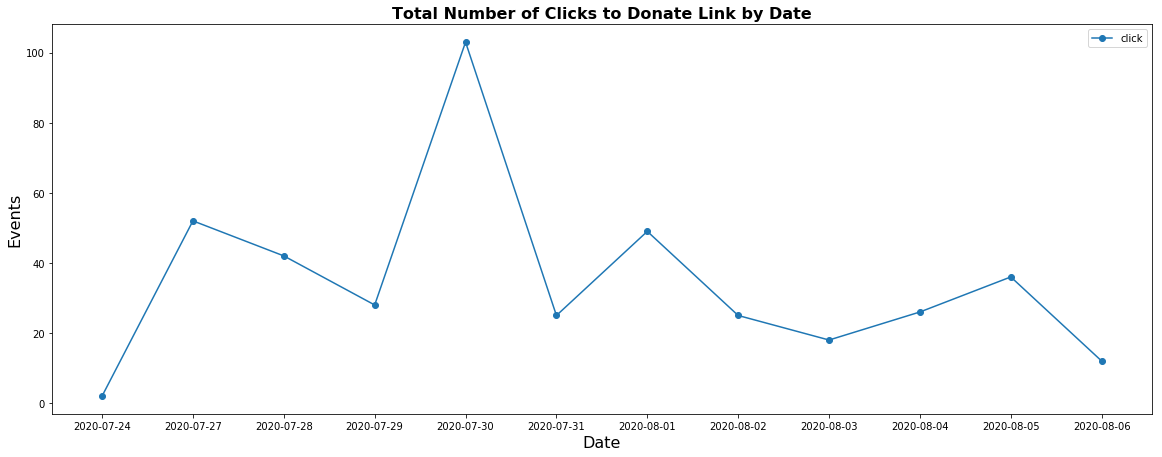

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(16,6))
fig.tight_layout(pad=1.08, w_pad=0.5, h_pad=6)
ax.set_title('Total Number of Clicks to Donate Link by Date',fontweight="bold",fontsize = 16)
ax.set_xlabel('Date',  fontsize = 16)
ax.set_ylabel('Events',  fontsize = 16)
ax.plot(count_donate_events_pivot["date"], 
        count_donate_events_pivot['events'], 'o-', label='click')

#ax.yaxis.set_major_formatter(thousand_formatter)
ax.legend(loc='upper right')

plt.show()

In [48]:
# Donate link events by Wiki

count_donate_wiki = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.name as name,
  wiki AS wiki,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND ((month=7 AND day > 23) OR month=8)   
  AND event.name LIKE 'n-site%'
GROUP BY date_format(dt, "yyyy-MM-dd"), event.name, wiki
""")

### Donate link clicks by Wiki

In [81]:
count_donate_wiki.pivot_table(index=['wiki'], columns=['date']).fillna(0)

events                                              \
date          2020-07-24 2020-07-27 2020-07-28 2020-07-29 2020-07-30   
wiki                                                                   
euwiki               0.0        5.0        0.0        0.0        0.0   
fawiki               0.0        1.0        4.0        7.0       36.0   
frwiki               0.0        2.0       24.0       17.0       34.0   
frwiktionary         0.0        4.0        0.0        1.0        0.0   
hewiki               0.0        1.0       12.0        3.0       29.0   
ptwikiversity        0.0        2.0        0.0        0.0        2.0   
testwiki             2.0       37.0        2.0        0.0        2.0   

                                                                      \
date          2020-07-31 2020-08-01 2020-08-02 2020-08-03 2020-08-04   
wiki                                                                   
euwiki               0.0        1.0        2.0        0.0        2.0   
fawiki               3.0       21.0        5.0        3.0       10.0   
frwiki              17.0       17.0       12.0       11.0       11.0   
frwiktionary         1.0        0.0        1.0        0.0        0.0   
hewiki               4.0        0.0        3.0        4.0        3.0   
ptwikiversity        0.0        0.0        0.0        0.0        0.0   
testwiki             0.0       10.0        2.0        0.0        0.0   

                                     
date          2020-08-05 2020-08-06  
wiki                                 
euwiki               0.0        0.0  
fawiki               7.0        3.0  
frwiki              20.0        7.0  
frwiktionary         1.0        0.0  
hewiki               8.0        2.0  
ptwikiversity        0.0        0.0  
testwiki             0.0        0.0

In [50]:
# Donate link events on Wikis by skinVersion

count_donate_skinVersion= hive.run("""
SELECT
  event.skinversion,
  event.name as name,
  wiki AS wiki,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND ((month=7 AND day > 20) OR month=8)   
  AND event.name LIKE 'n-sitesupport'
GROUP BY event.skinversion, event.name, wiki
""")

### Donate link clicks by Skin Version


In [51]:
count_donate_skinVersion.pivot_table(index=['name','skinversion'], columns=['wiki']).fillna(0)

events                                    \
wiki                      euwiki fawiki frwiki frwiktionary hewiki   
name          skinversion                                            
n-sitesupport 1              0.0    2.0  135.0          0.0   13.0   
              2             10.0   98.0   37.0          8.0   56.0   

                                                  
wiki                      ptwikiversity testwiki  
name          skinversion                         
n-sitesupport 1                     0.0    125.0  
              2                     4.0    274.0

<font color='dark red'>
    Looks like the new skinVersion is driving traffic toward the Donate link on Fa, Eu, He wikis ! 
</font>

In [52]:
# Donate link events by logged in/out users

count_donate_skinVersion_anon= hive.run("""
SELECT
  event.skinversion,
  event.name as name,
  wiki AS wiki,
  event.isanon AS anonymous_user,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND ((month=7 AND day > 19) OR month=8)   
  AND event.name LIKE 'n-sitesupport'
GROUP BY event.skinversion, event.name, wiki, event.isanon 
""")

### Donate link clicks by Skin Version and logged in/out users

In [53]:
count_donate_skinVersion_anon.pivot_table(index=['name','anonymous_user','skinversion'], 
                                          columns=['wiki']).fillna(0)

events                             \
wiki                                     euwiki fawiki frwiki frwiktionary   
name          anonymous_user skinversion                                     
n-sitesupport False          1              0.0    0.0    4.0          0.0   
                             2              0.0    2.0    1.0          0.0   
              True           1              0.0    2.0  131.0          0.0   
                             2             10.0   96.0   36.0          8.0   

                                                                        
wiki                                     hewiki ptwikiversity testwiki  
name          anonymous_user skinversion                                
n-sitesupport False          1              6.0           0.0     59.0  
                             2              2.0           0.0    164.0  
              True           1              7.0           0.0     76.0  
                             2             54.0           4.0    122.0

<font color='dark red'>
 The rise in traffic for Donate link on Fa, Eu, He wikis is driven by Anonymous i.e. Logged Out users (default skinversion 2)
</font>

In [54]:
# Donate link events by logged in/out users by day

count_donate_skinVersion_anon_day= hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.skinversion,
  event.name as name,
  wiki AS wiki,
  event.isanon AS anonymous_user,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 AND day>23
  AND event.name LIKE 'n-sitesupport'
GROUP BY date_format(dt, "yyyy-MM-dd"),event.skinversion, event.name, wiki, event.isanon 
""")

### Daily count of Donate link clicks by Skin Version for logged in/out users

In [55]:
count_donate_skinVersion_anon_day.pivot_table(index=
                                              ['name','anonymous_user','skinversion','date'], 
                                              columns=['wiki']).fillna(0)

events                \
wiki                                                euwiki fawiki frwiki   
name          anonymous_user skinversion date                              
n-sitesupport False          1           2020-07-28    0.0    0.0    0.0   
                                         2020-07-29    0.0    0.0    0.0   
                                         2020-07-30    0.0    0.0    2.0   
                                         2020-07-31    0.0    0.0    1.0   
                             2           2020-07-30    0.0    0.0    0.0   
              True           1           2020-07-24    0.0    0.0    0.0   
                                         2020-07-27    0.0    1.0    2.0   
                                         2020-07-28    0.0    1.0   24.0   
                                         2020-07-29    0.0    0.0   17.0   
                                         2020-07-30    0.0    0.0   12.0   
                                         2020-07-31    0.0    0.0   16.0   
                             2           2020-07-27    5.0    0.0    0.0   
                                         2020-07-28    0.0    3.0    0.0   
                                         2020-07-29    0.0    7.0    0.0   
                                         2020-07-30    0.0   36.0   20.0   
                                         2020-07-31    0.0    3.0    0.0   

                                                                         \
wiki                                                frwiktionary hewiki   
name          anonymous_user skinversion date                             
n-sitesupport False          1           2020-07-28          0.0    4.0   
                                         2020-07-29          0.0    1.0   
                                         2020-07-30          0.0    0.0   
                                         2020-07-31          0.0    0.0   
                             2           2020-07-30          0.0    1.0   
              True           1           2020-07-24          0.0    0.0   
                                         2020-07-27          0.0    1.0   
                                         2020-07-28          0.0    6.0   
                                         2020-07-29          0.0    0.0   
                                         2020-07-30          0.0    0.0   
                                         2020-07-31          0.0    0.0   
                             2           2020-07-27          4.0    0.0   
                                         2020-07-28          0.0    2.0   
                                         2020-07-29          1.0    2.0   
                                         2020-07-30          0.0   28.0   
                                         2020-07-31          1.0    4.0   

                                                                            
wiki                                                ptwikiversity testwiki  
name          anonymous_user skinversion date                               
n-sitesupport False          1           2020-07-28           0.0      0.0  
                                         2020-07-29           0.0      0.0  
                                         2020-07-30           0.0      0.0  
                                         2020-07-31           0.0      0.0  
                             2           2020-07-30           0.0      0.0  
              True           1           2020-07-24           0.0      2.0  
                                         2020-07-27           0.0      0.0  
                                         2020-07-28           0.0      1.0  
                                         2020-07-29           0.0      0.0  
                                         2020-07-30           0.0      0.0  
                                         2020-07-31           0.0      0.0  
                             2           2020-07-27           2.0     37.0  
                          

In [56]:
# Other Sidebar links

count_sidebar_links_click= hive.run("""
SELECT
  event.skinversion,
  event.isanon AS anonymous_user,
  event.name as name,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND ((month=7 AND day > 23) OR month=8)   
  AND event.name LIKE 'n-%' 
  AND wiki <> 'testwiki' 
  
GROUP BY event.skinversion, event.name, event.isanon 
""")

### Clicks to other sidebar links that have been logged in the schema

In [57]:
count_sidebar_links_click.head()

,skinversion,anonymous_user,name,events
0,1,False,n-contactUs,1
1,1,False,n-currentevents,6
2,1,True,n-news,3
3,1,True,n-portals,2
4,1,True,n-welcomepage,4


## Verifying a few row of data in the schema

In [58]:
# Random data check

Check_few_rows1 = hive.run("""
SELECT
  event.skin,
  event.action, 
  event.skinversion,
  event.name as name,
  event.isanon AS anonymous_user,
  event.token,
  event.isSidebarCollapsed,
  event.editCountBucket
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=8 AND day=3 AND hour=11
  AND wiki <> 'testwiki' 
LIMIT 15  
""")

In [59]:
Check_few_rows

,skin,action,skinversion,name,anonymous_user,token,issidebarcollapsed,editcountbucket,token.1
0,vector,init,2,NaN,True,3f82f8121e707b9ac52d,False,0 edits,3f82f8121e707b9ac52d
1,vector,init,1,NaN,False,13900f81d0d31a59cca8,False,5-99 edits,13900f81d0d31a59cca8
2,vector,init,2,NaN,True,5e54689272a46324b3f3,False,0 edits,5e54689272a46324b3f3
3,vector,init,1,NaN,True,bf70d9052b9c8e353d70,False,0 edits,bf70d9052b9c8e353d70
4,vector,init,1,NaN,False,30c602154e3c01891a1d,False,1000+ edits,30c602154e3c01891a1d
5,vector,init,1,NaN,True,6ee2d86e1ae3c92dec83,False,0 edits,6ee2d86e1ae3c92dec83
6,vector,init,2,NaN,True,7a05f912bef3907ffaf1,False,0 edits,7a05f912bef3907ffaf1
7,vector,init,2,NaN,True,0955bbce5f1d55e98237,False,0 edits,0955bbce5f1d55e98237
8,vector,init,1,NaN,True,e16f00bd0b08a4551ec3,False,0 edits,e16f00bd0b08a4551ec3
9,vector,init,1,NaN,True,1acce9a301c537b99613,False,0 edits,1acce9a301c537b99613


In [ ]:
# Random data check

Check_few_rows2 = hive.run("""
SELECT
  event.skin,
  event.action, 
  event.skinversion,
  event.name as name,
  event.isanon AS anonymous_user,
  event.token,
  event.isSidebarCollapsed,
  event.editCountBucket
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=8 AND day=4 AND hour=10
  AND wiki <> 'testwiki' 
  AND event.name IS NOT NULL
LIMIT 15  
""")

In [ ]:
Check_few_rows2